In [1]:
from helper import *
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import duckdb
from collections import Counter
from IPython.display import display as dp
import warnings
from sklearn.exceptions import FitFailedWarning

# Filter out FutureWarnings
warnings.simplefilter(action="ignore", category=FutureWarning)
# Filter out FitFailedWarning
warnings.filterwarnings(action="ignore", category=FitFailedWarning)
# Filter out UserWarning
warnings.filterwarnings(action="ignore", category=UserWarning)

pd.options.display.max_columns = None

sns.set_style("darkgrid")

### Modeling
In the feature selection notebook, 3 predictors, `player_score_mean_diff`, \
`past_game_result_diff` and `formation_win_rate_diff`, were selected for \
modeling.

The main goal is to use **Logistic Regression** to predict `game result` for season \
2015/2016 based on model trained by data from season 2008/2009 ~ 2014/2015.

From the EDA home advantage is observed, the predictors we are using is \
the difference of home - away team in games, thus we don't need to address home \
advantage here.

Also, as teams compete *within* the leagues, we would also test out if using \
separate models for each country yields better result than model trained on all \
country data. 

In [2]:
# load modeling data
soccer1 = pd.read_csv("./data/soccer_modeling.csv")
dp(soccer1.head(3))

,game_id,country,season,home_team_id,away_team_id,player_score_mean_diff,past_game_result_diff,formation_win_rate_diff,game_result,goal_diff
0,25243,Switzerland,2011/2012,7730,10179,-3.0,-0.573451,0.086957,away_wins,-2
1,25252,Switzerland,2011/2012,7730,10192,-5.0,-0.893168,0.166517,away_wins,-3
2,25113,Switzerland,2011/2012,7730,10191,-1.0,-0.700193,0.086957,home_wins,1


📊 Train-test split: \
Manually separate testing and training data.
Also separate country data for the model training on individual country.

>Train Data: season 2008/2009 ~ 2014/2015

>Test Data: season 2015/2016


In [3]:
all_countries = list(soccer1.country.unique())
all_countries_count = dict(Counter(soccer1.country))

predictors = [
    "player_score_mean_diff",
    "past_game_result_diff",
    "formation_win_rate_diff",
]

country_predictors = [
    "country",
    "player_score_mean_diff",
    "past_game_result_diff",
    "formation_win_rate_diff",
]

target = ["country", "game_result"]


def get_train(df):
    train = df.loc[df.season != "2015/2016"]
    return train


def get_test(df):
    test = df.loc[df.season == "2015/2016"]

    return test


def get_X(df, pred):
    predictor_df = df[pred]
    return predictor_df


def get_y(df, target):
    target_df = df[target]
    return target_df


def separate_country(df, is_y=False):
    df_dict = {}
    for i in all_countries:
        country_df = df.loc[df.country == i]
        if is_y:
            df_dict[i] = country_df.loc[:,
                                        country_df.columns != "country"].game_result
        else:
            df_dict[i] = country_df.loc[:, country_df.columns != "country"]
    return df_dict


# all data


X_train = soccer1.pipe(get_train).pipe(get_X, predictors)
y_train = soccer1.pipe(get_train).game_result

X_test = soccer1.pipe(get_test).pipe(get_X, predictors)
y_test = soccer1.pipe(get_test).game_result

bprint("X_train shape")
print(X_train.shape)

bprint("X_test shape")
print(X_test.shape)

bprint("X_train data: ")
dp(X_train.head(3))

# country specific
X_train_country = separate_country(
    soccer1.pipe(get_train).pipe(get_X, country_predictors)
)
y_train_country = separate_country(
    soccer1.pipe(get_train).pipe(get_y, target), is_y=True
)

X_test_country = separate_country(
    soccer1.pipe(get_test).pipe(get_X, country_predictors)
)
y_test_country = separate_country(soccer1.pipe(
    get_test).pipe(get_y, target), is_y=True)

bprint("country separated train data (eg: X_train_france")
dp(X_train_country["France"].head(3))


X_train shape
(22641, 3)

X_test shape
(3326, 3)

X_train data: 


,player_score_mean_diff,past_game_result_diff,formation_win_rate_diff
0,-3.0,-0.573451,0.086957
1,-5.0,-0.893168,0.166517
2,-1.0,-0.700193,0.086957



country separated train data (eg: X_train_france


,player_score_mean_diff,past_game_result_diff,formation_win_rate_diff
324,1.0,2.0,0.166517
325,2.0,0.0,0.140288
326,-5.0,0.0,0.194853


📊 Check the feature distribution of train and test data to ensure \
that our training data is relevant.

Both *total data* and *data separated by country* are plotted.

1. All data

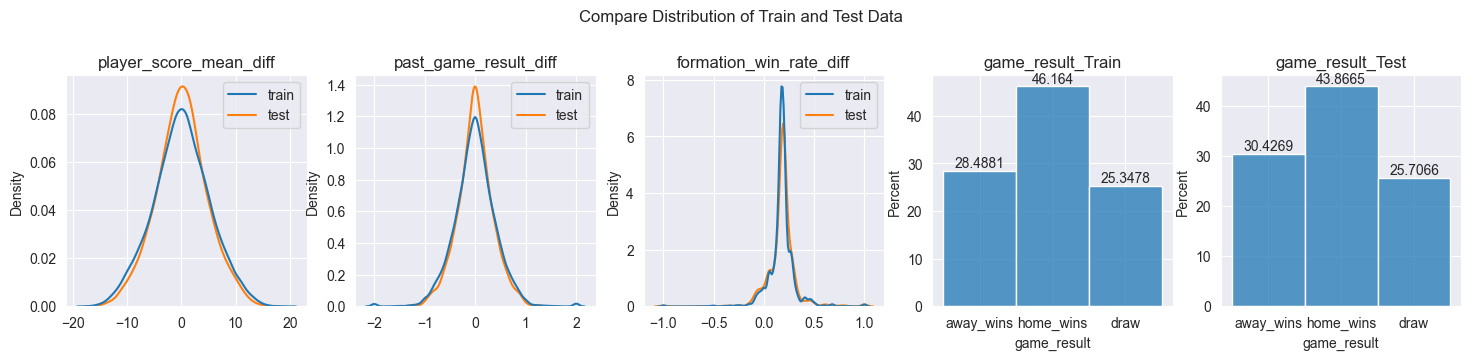

In [4]:
fs(18, 3)
plt.suptitle("Compare Distribution of Train and Test Data", y=1.1)
plt.subplot(1, 5, 1)
sns.kdeplot(
    pd.DataFrame(
        {"train": X_train.player_score_mean_diff,
            "test": X_test.player_score_mean_diff}
    ),
    common_norm=False,
)
plt.title("player_score_mean_diff")
plt.subplot(1, 5, 2)
sns.kdeplot(
    pd.DataFrame(
        {"train": X_train.past_game_result_diff,
            "test": X_test.past_game_result_diff}
    ),
    common_norm=False,
)
plt.title("past_game_result_diff")

plt.subplot(1, 5, 3)
sns.kdeplot(
    pd.DataFrame(
        {
            "train": X_train.formation_win_rate_diff,
            "test": X_test.formation_win_rate_diff,
        }
    ),
    common_norm=False,
)
plt.title("formation_win_rate_diff")


plt.subplot(1, 5, 4)
ax = sns.histplot(y_train, stat="percent")
mark_bar(ax)
plt.title("game_result_Train")
plt.subplot(1, 5, 5)
ax = sns.histplot(y_test, stat="percent")
mark_bar(ax)
plt.title("game_result_Test")
s()

2. Country Data

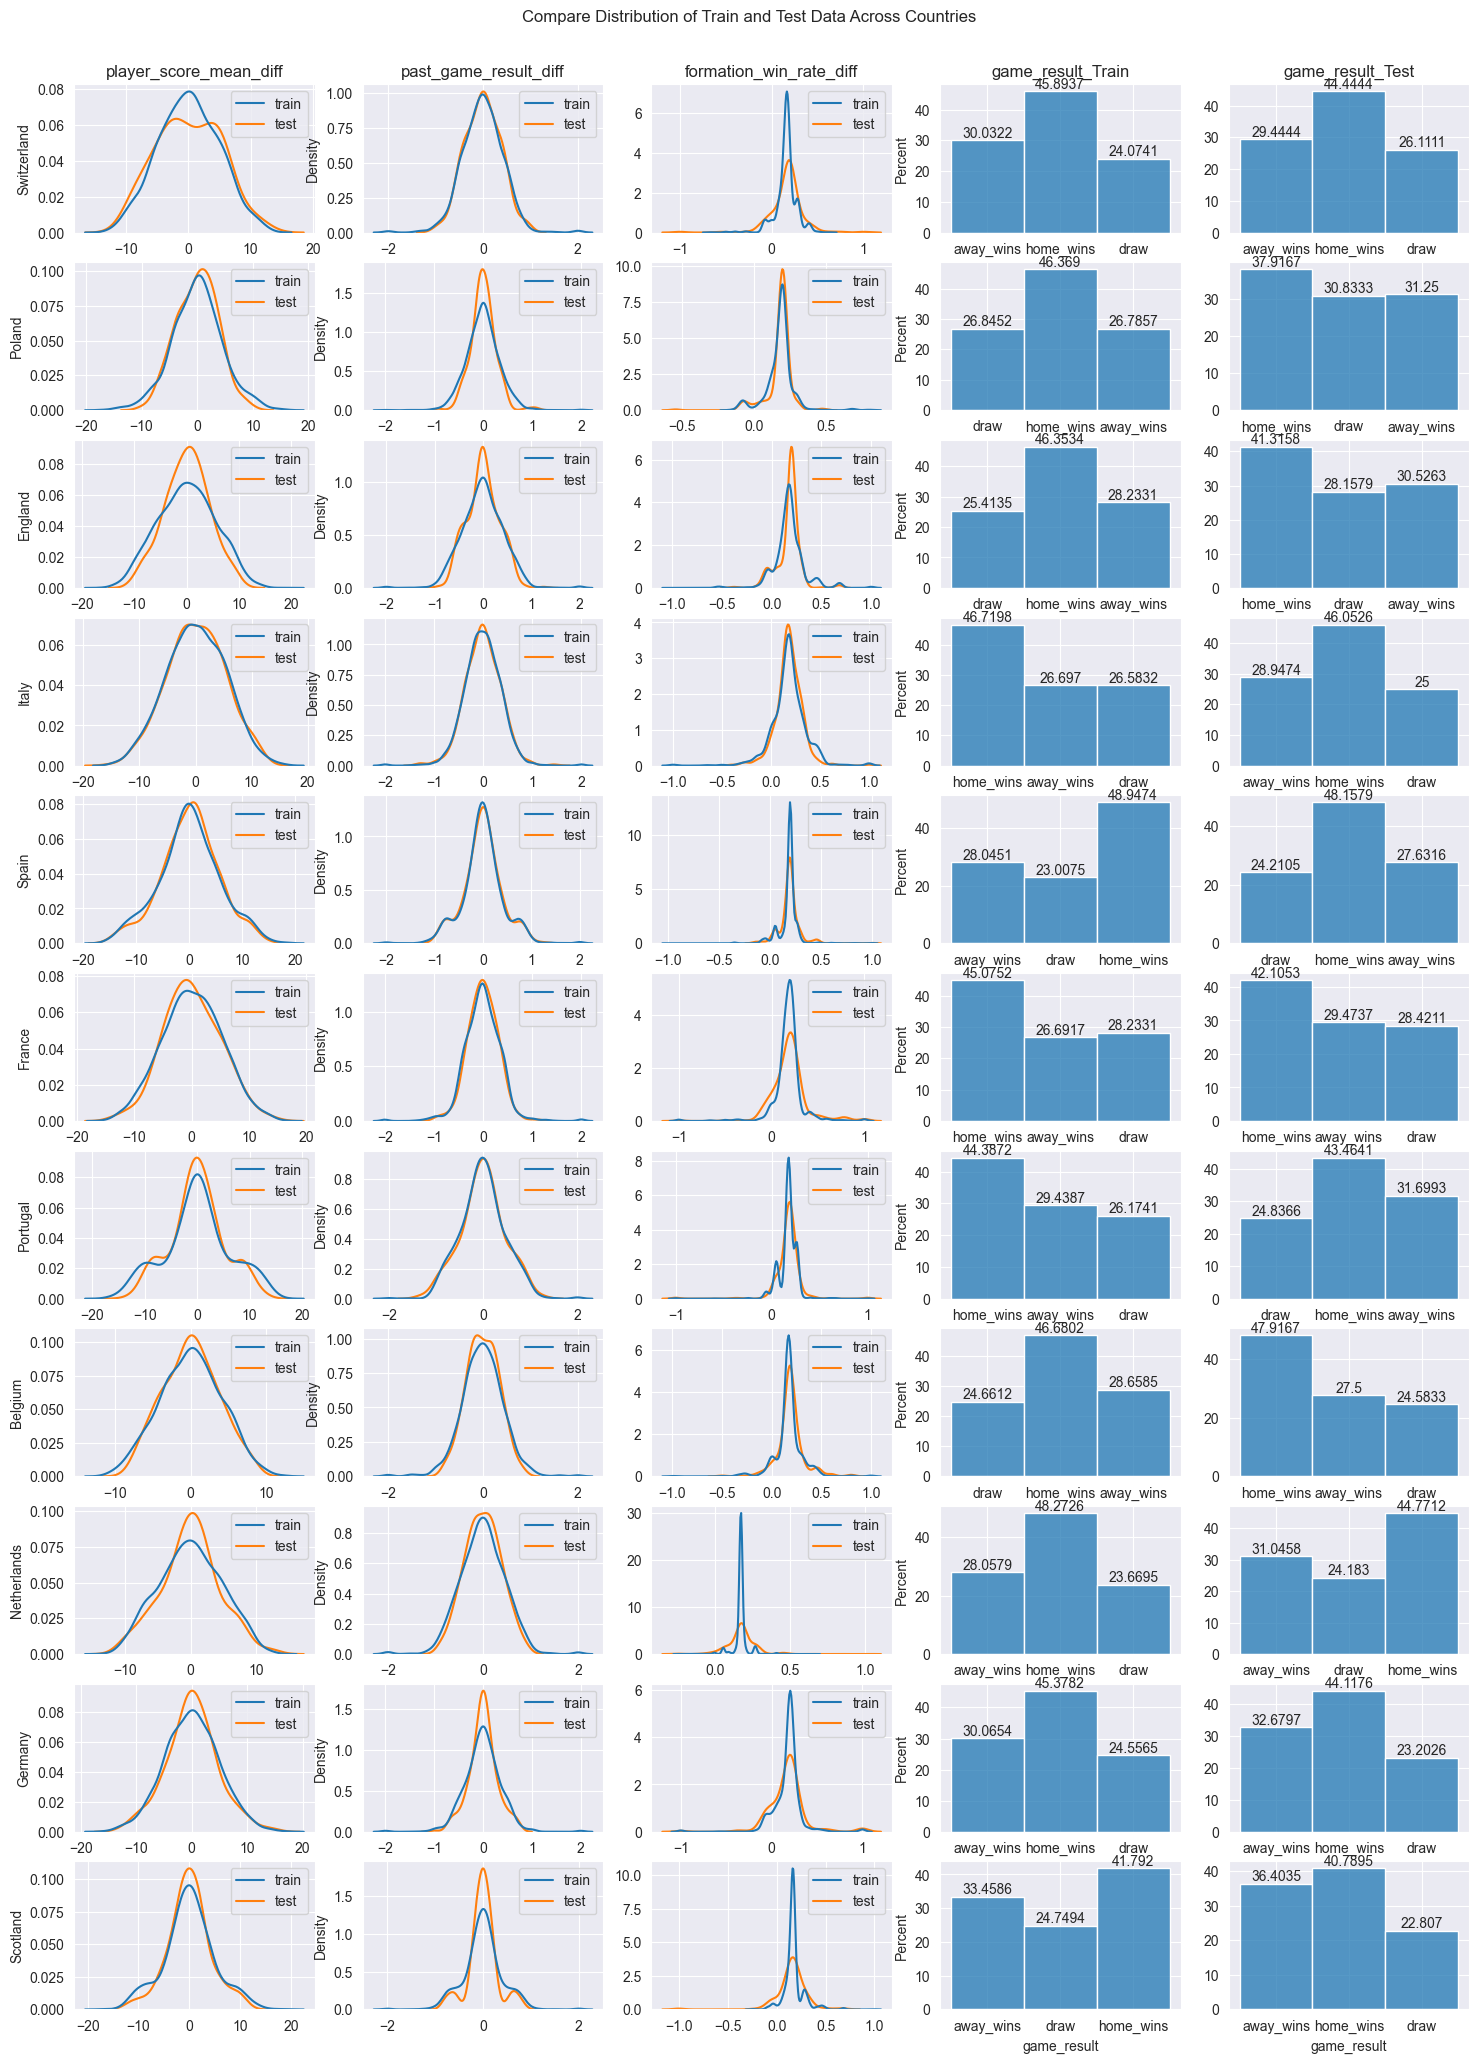

In [5]:
fs(18, 25)
plt.suptitle(
    "Compare Distribution of Train and Test Data Across Countries",
    y=0.91,
)
plt_count = 1
for country in all_countries:
    plt.subplot(11, 5, plt_count)
    sns.kdeplot(
        pd.DataFrame(
            {
                "train": X_train_country[country].player_score_mean_diff,
                "test": X_test_country[country].player_score_mean_diff,
            }
        ),
        common_norm=False,
    )

    plt.ylabel(country)
    if plt_count < 6:
        plt.title("player_score_mean_diff")

    plt_count += 1
    plt.subplot(11, 5, plt_count)
    sns.kdeplot(
        pd.DataFrame(
            {
                "train": X_train_country[country].past_game_result_diff,
                "test": X_test_country[country].past_game_result_diff,
            }
        ),
        common_norm=False,
    )
    # plt.ylabel("")
    if plt_count < 6:
        plt.title("past_game_result_diff")
    plt_count += 1
    plt.subplot(11, 5, plt_count)
    sns.kdeplot(
        pd.DataFrame(
            {
                "train": X_train_country[country].formation_win_rate_diff,
                "test": X_test_country[country].formation_win_rate_diff,
            }
        ),
        common_norm=False,
    )
    plt.ylabel("")
    if plt_count < 6:
        plt.title("formation_win_rate_diff")

    # fs(8, 3)
    # plt.suptitle("Target distribution of Train and Test data")
    plt_count += 1
    plt.subplot(11, 5, plt_count)
    ax = sns.histplot(y_train_country[country], stat="percent")
    mark_bar(ax)
    if plt_count < 6:
        plt.title("game_result_Train")
    plt_count += 1
    plt.subplot(11, 5, plt_count)
    ax = sns.histplot(y_test_country[country], stat="percent")
    mark_bar(ax)
    if plt_count < 6:
        plt.title("game_result_Test")
    plt.ylabel("")

    plt_count += 1

📝 Compare train and test data distribution

Independent Variables:

- player_score and past_game_result: \
For most countries, distribution of these two features matches well for train \
and test group.
Most countries have some mismatch in the middle of the distribution curve, \
due to the fact that the training data has much more samples, it has a \
a wider distribution curve that is closer to bell shape.

- formation_win_rate: \
The tran and test distribution formation_win_rate_diff does not match well for \
some countries, the train data has strong central tendency while the test data \
is closer to bell curve. The reason is because while there is much more formation \
combinations in train data, many of them have similar formation_win_diff. \

Dependent Variable: 
- The distribution of the three target classes is mostly similar between train \
and test of different countries. The three classes are not balanced in all \
countries.

📊 Preprocessing & Modeling

As `Logistic Regression` would be applied here, `StandardScaler` would be used to \
scale all features

Mean value is used to impute missing data. \
(median and endtail imputing were tested out, there's no impact on the metrics) 

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from feature_engine.imputation import MeanMedianImputer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

📊 Model trained with all data: 

In [7]:
# columns to impute
imp_col = ["formation_win_rate_diff", "player_score_mean_diff"]

# preprocessing steps
preprocess = Pipeline(
    steps=[
        (
            "median_impute",
            MeanMedianImputer(
                imputation_method="median",
                variables=imp_col,
            ),
        ),
        ("scale", StandardScaler()),
    ]
)


# class weight balance not specified
base_model = Pipeline(
    [
        ("preprocess", preprocess),
        (
            "grid_search",
            RandomizedSearchCV(
                estimator=LogisticRegression(
                    solver="lbfgs",
                ),
                param_distributions={
                    "C": [0.001, 0.01, 0.1, 1, 10],
                    "multi_class": ["multinomial", "ovr"],
                    "penalty": ["l1", "l2"],
                },
                cv=5,
            ),
        ),
    ]
)


def get_tuned_model(model):
    # fit model
    model.fit(X_train, y_train)
    # get best hyper params
    tuned_logit = model[-1].best_estimator_
    model_t = Pipeline([("preprocess", preprocess), ("logit", tuned_logit)])
    return model_t


base_model_t = get_tuned_model(base_model)
bprint("Base Model")
base_model_t.fit(X_train, y_train)


Base Model


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('median_impute',
                                  MeanMedianImputer(variables=['formation_win_rate_diff',
                                                               'player_score_mean_diff'])),
                                 ('scale', StandardScaler())])),
                ('logit', LogisticRegression(C=0.01, multi_class='ovr'))])

In [8]:
# model with balanced class weight
balanced_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "grid_search",
            RandomizedSearchCV(
                estimator=LogisticRegression(
                    solver="lbfgs",
                    class_weight="balanced",
                ),
                param_distributions={
                    "C": [0.001, 0.01, 0.1, 1, 10],
                    "multi_class": ["multinomial", "ovr"],
                    "penalty": ["l1", "l2"],
                },
                cv=5,
            ),
        ),
    ]
)

# get best hyper params
balanced_model_t = get_tuned_model(balanced_model)
bprint("Balanced Model")
balanced_model_t.fit(X_train, y_train)


Balanced Model


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('median_impute',
                                  MeanMedianImputer(variables=['formation_win_rate_diff',
                                                               'player_score_mean_diff'])),
                                 ('scale', StandardScaler())])),
                ('logit',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    multi_class='ovr'))])

📝 Model and Class balanced model:

There are 3 target classes (home_wins, draw, away_wins), and the size of the \
3 classes  differs (46%, 28%, 25%), we test out two models here, \
LogisticRegression without class balance and with class balance.

As there are only 3 features in this model, ridge (l2) is chosen instead of \
lasso (l1) to penalize large coefficients but not shrinking them to 0.

RandomSearch is applied to find the most suitable parameters for both logit models.

> RandomSearch has chosen different params for basic (imbalance) and balanced model:

> - `multi_class` : the imbalance model is using multinomial option, while the balanced \
> model is using ovr. 

> - `c (1/regularization strength)`: the regularization strength of balanced model \
> is stronger than the imbalance model. 

In [9]:
# cross validation
bprint("Cross Validation Score")
cv = cross_val_score(base_model_t, X_train, y_train)
balanced_cv = cross_val_score(balanced_model_t, X_train, y_train)

bprint("Base Model")
print(cv)
print("mean:", round(np.mean(cv), 2))
bprint("Balanced Model")
print(balanced_cv)
print("mean:", round(np.mean(balanced_cv), 2))


Cross Validation Score

Base Model
[0.5299183  0.53246466 0.52120141 0.51833039 0.53754417]
mean: 0.53

Balanced Model
[0.50761758 0.50154594 0.48520318 0.49558304 0.51899293]
mean: 0.5


📝 Cross Validation \
The cross validation score of base model is slightly better than the balanced model. \
The base model has weaker regularization term, thus the model would fit better \
but also has higer chance to overfit.

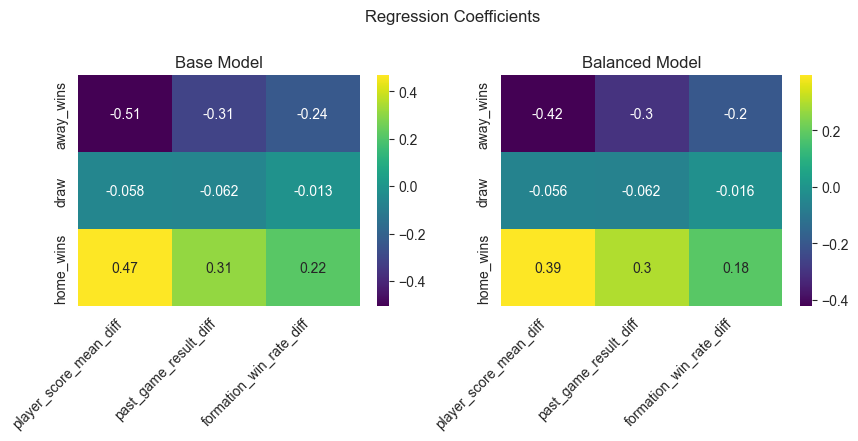

In [10]:
# model coefficients
base_coefficients = pd.DataFrame(
    base_model_t[-1].coef_,
    index=base_model_t[-1].classes_,
    columns=X_train.columns,
)

# balanced_model_t coefficients
balanced_coefficients = pd.DataFrame(
    balanced_model_t[-1].coef_,
    index=balanced_model_t[-1].classes_,
    columns=X_train.columns,
)

# coefficient plots
fs(10, 3)
plt.subplot(1, 2, 1)
plt.suptitle("Regression Coefficients", y=1.1)
plt.title("Base Model")
sns.heatmap(base_coefficients, annot=True, cmap="viridis")
plt.xticks(rotation=45, ha="right")

plt.subplot(1, 2, 2)
plt.title("Balanced Model")
sns.heatmap(balanced_coefficients, annot=True, cmap="viridis")
plt.xticks(rotation=45, ha="right")
s()

📝 Base and Balanced models coefficients
- For both models, predictor strength is as followed: \
player_score > past_game_result > fomation_win_rate_diff

- As all predictors are the difference of home and away, the coefficients for \
away_wins are mostly just the negative of home_wins.

- The coefficients for draw in both models are very small, it is hard for both \
models to classify draw. However, in balanced model the draw coefficients is \
almost 4 ~ 10 times larger than ones in the base model.



Confision Matrix


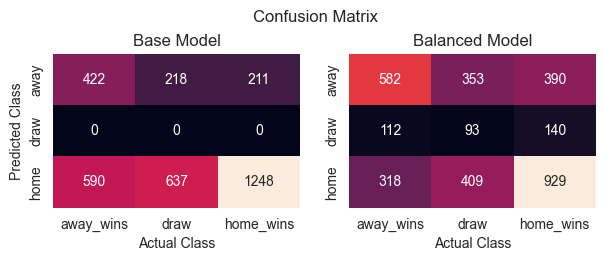


Prediction Report: 


Base Model:
              precision    recall  f1-score   support

   away_wins       0.50      0.42      0.45      1012
        draw       1.00      0.00      0.00       855
   home_wins       0.50      0.86      0.63      1459

    accuracy                           0.50      3326
   macro avg       0.67      0.42      0.36      3326
weighted avg       0.63      0.50      0.42      3326


Balanced Model:
              precision    recall  f1-score   support

   away_wins       0.44      0.58      0.50      1012
        draw       0.27      0.11      0.15       855
   home_wins       0.56      0.64      0.60      1459

    accuracy                           0.48      3326
   macro avg       0.42      0.44      0.42      3326
weighted avg       0.45      0.48      0.45      3326



In [11]:
# model prediction
y_pred_base = base_model_t.predict(X_test)
y_pred_balanced = balanced_model_t.predict(X_test)

# confusion matrix
bprint("Confision Matrix")
base_confusion_mtx = pd.DataFrame(confusion_matrix(y_test, y_pred_base).T)
balanced_confusion_mtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred_balanced).T)

fs(7, 2)
plt.suptitle("Confusion Matrix", y=1.1)
plt.subplot(1, 2, 1)
sns.heatmap(base_confusion_mtx, annot=True, fmt="", cbar="")
plt.title("Base Model")
plt.xticks([0.5, 1.5, 2.5], ["away_wins", "draw", "home_wins"])
plt.yticks([0.5, 1.5, 2.5], ["away", "draw", "home"])
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")

plt.subplot(1, 2, 2)
sns.heatmap(balanced_confusion_mtx, annot=True, fmt="", cbar="")
plt.title("Balanced Model")
plt.xticks([0.5, 1.5, 2.5], ["away_wins", "draw", "home_wins"])
plt.yticks([0.5, 1.5, 2.5], ["away", "draw", "home"])
plt.xlabel("Actual Class")
s()

# model classification report
bprint("Prediction Report: \n")
report = classification_report(y_test, y_pred_base, zero_division=1)
bprint("Base Model:")
print(report)

# balanced model classification report
balanced_report = classification_report(
    y_test, y_pred_balanced, zero_division=1)
bprint("Balanced Model:")
print(balanced_report)

📝 Confusion Matrix & Prediction report:
- The accuracy for base model is 0.5, balanced model is 0.48, it performs both \
about 2~3% worse than cross validaiton. 

**Base Model (imbalance)**
- No games is predicted to be draw. 
- The recall of home_wins is 0.85, but the precision is only 0.51.
- The f1 of away_wins is 0.46.

> This imabalance model failed to predict draw, circa 70% of draws were predicted \
> home_wins. It also did a bad job predicting away_wins, more away_wins were \
> predicted home_wins. But it captures home_wins well, the recall is 85%. 

**Balanced Model**
- This model predicted draw, but with only 0.26 precision.
- It does a better job capturing away wins than the imbalance model, f1 = 0.5 .
- The recall of home_wins dropped to 0.63, but the precision has a 5% increase.

> The balanced model predict 3 classes, but it did the draw prediction poorly. \
> The away_wins prediction is slightly better than the imbalance model, but the \
> recall of home_wins is 20% worse.

In [12]:
# metrics average:
# base
accuracy = accuracy_score(y_test, y_pred_base)

precision = precision_score(
    y_test, y_pred_base, average="weighted", zero_division=1)
recall = recall_score(y_test, y_pred_base, average="weighted")
f1 = f1_score(y_test, y_pred_base, average="weighted")

model_metrics_df = pd.DataFrame(
    {
        "accuracy": [accuracy],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1],
        "name": "base_model",
    },
)

# balanced
accuracy = accuracy_score(y_test, y_pred_balanced)

precision = precision_score(
    y_test, y_pred_balanced, average="weighted", zero_division=1
)
recall = recall_score(y_test, y_pred_balanced, average="weighted")
f1 = f1_score(y_test, y_pred_balanced, average="weighted")


model_metrics_df.loc[1] = [accuracy, precision, recall, f1, "balanced_model"]

📊 Would training and testing countries separately yield better models ?

- Country separated

In [13]:
# train and fit base model on individual country data
base_country_model_df = pd.DataFrame(
    index=["accuracy", "precision", "recall", "f1"])
for i in all_countries:
    base_model.fit(X_train_country[i], y_train_country[i])
    base_country_model = get_tuned_model(base_model)
    y_pred = base_country_model.predict(X_test_country[i])

    accuracy = accuracy_score(y_test_country[i], y_pred)
    precision = precision_score(
        y_test_country[i], y_pred, average="weighted", zero_division=1
    )
    recall = recall_score(y_test_country[i], y_pred, average="weighted")
    f1 = f1_score(y_test_country[i], y_pred, average="weighted")

    base_country_model_df[i] = [accuracy, precision, recall, f1]

# train and fit balanced model on country data
balanced_country_model_df = pd.DataFrame(
    index=["accuracy", "precision", "recall", "f1"]
)
for i in all_countries:
    balanced_model.fit(X_train_country[i], y_train_country[i])
    balanced_country_model = get_tuned_model(balanced_model)
    y_pred = balanced_model.predict(X_test_country[i])

    accuracy = accuracy_score(y_test_country[i], y_pred)
    precision = precision_score(
        y_test_country[i], y_pred, average="weighted", zero_division=1
    )
    recall = recall_score(y_test_country[i], y_pred, average="weighted")
    f1 = f1_score(y_test_country[i], y_pred, average="weighted")

    balanced_country_model_df[i] = [accuracy, precision, recall, f1]

KeyboardInterrupt: 

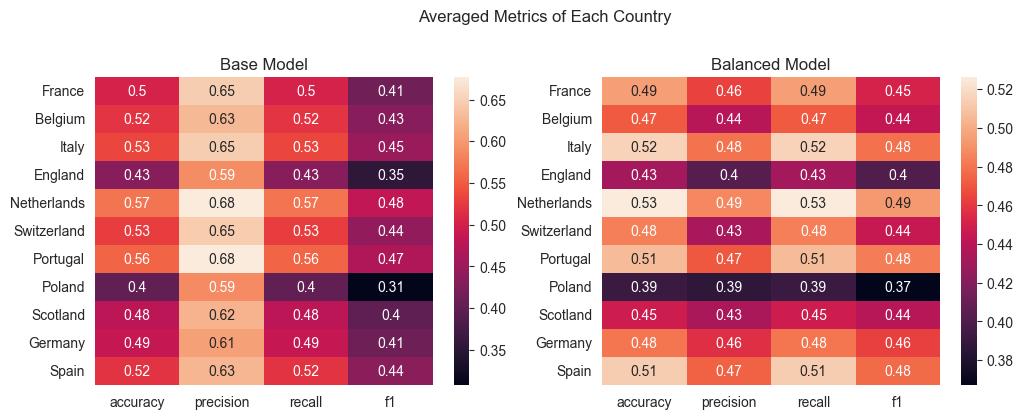

In [ ]:
fs(12, 4)
plt.subplot(1, 2, 1)
plt.suptitle("Averaged Metrics of Each Country", y=1.05)
sns.heatmap(base_country_model_df.T, annot=True)

plt.title("Base Model")

plt.subplot(1, 2, 2)

sns.heatmap(balanced_country_model_df.T, annot=True)
plt.title("Balanced Model")
s()

📝 Country specific models: \
Here the metrics of the 3 classes are averaged for the ease of comparison. 

The averaged metrics for base and balanced model for most countries are very \
similar with respective model that do not have countries separated. 

Countries like `Portugal and Netherlands have much better metrics than the full` \
`model`, while `Poland and England have worse performance than the full model`. 

Looking back at the feature distribution plots, we can observe that, if the feature \
distribution of a country is closer to all countries, then using model trained on \
full data have higher chance to give better results. \
On the contrary, if the feature distribution deviates a lot from all countries \
distribution , the model trained on individual country is more likely to give \
better result.

> This is the trade-off between having a model that trained with *more data* and \
> a model that is trained with less but *better*, more representative, data. 

In [ ]:
# add metrics to total comparison df
model_metrics_df.loc[2] = list(base_country_model_df.T.mean(axis=0)) + [
    "base_country_model"
]
model_metrics_df.loc[3] = list(balanced_country_model_df.T.mean(axis=0)) + [
    "balanced_country_model"
]

📊 Compare metrics of all four models \

note here: the country metrics is the average of all countries

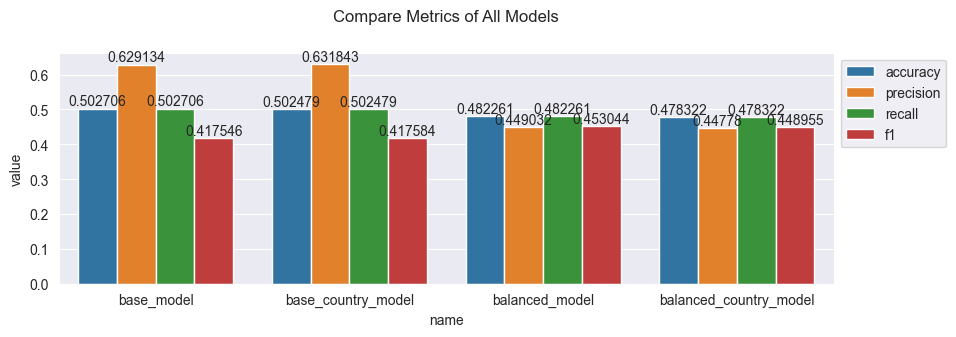

In [ ]:
fs(10, 3)
ax = sns.barplot(
    data=model_metrics_df.melt(
        id_vars="name", value_vars=["accuracy", "precision", "recall", "f1"]
    ),
    x="name",
    y="value",
    hue="variable",
    order=[
        "base_model",
        "base_country_model",
        "balanced_model",
        "balanced_country_model",
    ],
)
mark_bar(ax)
plt.title("Compare Metrics of All Models", y=1.1)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
s()

📝 Comparing all four models: 

Looking at the *averaged* metrics of country separated model, the metrics \
difference is very small. Combining with what we have observed from looking \
at the country specific metrics, the effects for individual countries were \
cancelled out.

🦄 Did the bookies do better in predicting the games ?

Let's take a look at how well the bookies predicted the games ! \
Note that we are using the average of all the bookies for all games here.

Follow this link to the [tableau dashboard](https://public.tableau.com/app/profile/mei.chieh.chien/viz/soccerprediction/Dashboard1?publish=yes).

💡 Modling Summary & Conclusion:

Here we put our main focus on testing out LogisticRegression model with \
different multiclasses options. \
Multinomial option is applied when we don't set the classes to be balanced, \
while OVR (one-versus-all) is applied when we force the classes to be balanced. 

Looking back in the EDA, the distribution of draw class in all predictors \
is always lying in the middle of home_wins and away_wins, thus it is hard to \
tell draw apart from the other two classes. Thus forcing OVR on it does not \
give very good result, we need better predictors.

For the country specific models, although the average metrics are similar to \
the none-country specific models, we can still spot some countries having better \
or worse metrics. A better model can be built if we combine the country-specific \
model and full model based on countries.

🍀 Possible Improvements:
1. Dig deeper into features, explore the characteristics of different countries \
to get better predictors. 

2. Explore clusters in the data, and do cluster analysis.

3. Instead of building the model on using the difference of teams in each games \
also look at the team overall performance.